# Predictive Analysis

In [168]:
import os
import numpy as np
import pandas as pd
import pycountry as pc
import re
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm 

sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    # directory = f"./TXT/Session {session} - {1945+session}"
    for filename in os.listdir(directory):
        # f = open(os.path.join(directory, filename))
        with open(os.path.join(directory, filename)) as f:
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech.tail()

,Session,Year,ISO-alpha3 Code,Speech
8476,75,2020,HRV,"Mr President, Excellencies\nAll protocol obser..."
8477,75,2020,GAB,"Mr. President, Majesties,\nLadies and Gentleme..."
8478,75,2020,MCO,"Mr. President of the General Assembly,\nMr. Se..."
8479,75,2020,AND,"Mr. President,\nMr. Secretary General,\nYour E..."
8480,75,2020,BHR,"In the name of Allah, the most gracious, the m..."


### Ensuring we have country names too (mainly used for experimentation and ease of use)

In [169]:
df_codes = pd.read_csv('UNSD — Methodology.csv', sep=";")
df_codes.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


In [171]:
df_un_merge =  pd.merge(df_codes, df_speech, how="right", on="ISO-alpha3 Code")[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code", "Session", "Year", "Speech"]]

## Loading in Labels and Merging with DF

In [173]:
df_dev = pd.read_csv('HDI.csv')[['ISO3', 'Human Development Groups']].rename(columns={'ISO3': 'ISO', 'HDI Rank (2021)': 'HDI'})
df_dev

,ISO,Human Development Groups
0,AFG,Low
1,AGO,Medium
2,ALB,High
3,AND,Very High
4,ARE,Very High
...,...,...
190,WSM,High
191,YEM,Low
192,ZAF,High
193,ZMB,Medium


In [175]:
df_un_merge =  pd.merge(df_codes, df_speech, how="right", on="ISO-alpha3 Code")[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code",  "Year", "Speech"]]
df_un_merge = df_un_merge.rename(columns={'ISO-alpha3 Code': 'ISO'}).dropna()
df_un_merge

,Country or Area,Region Name,Sub-region Name,ISO,Year,Speech
0,Austria,Europe,Western Europe,AUT,1970,155.\t May I begin by expressing to Ambassado...
1,Mexico,Americas,Latin America and the Caribbean,MEX,1970,"33.\t Mr. President, I take great pleasure in..."
2,Congo,Africa,Sub-Saharan Africa,COG,1970,122.\t I cannot begin my intervention without...
3,Algeria,Africa,Northern Africa,DZA,1970,1. The delegation of Algeria is very pleased ...
4,Sri Lanka,Asia,Southern Asia,LKA,1970,"176.\t Mr. President, the delegation of Ceylon..."
...,...,...,...,...,...,...
8476,Croatia,Europe,Southern Europe,HRV,2020,"Mr President, Excellencies\nAll protocol obser..."
8477,Gabon,Africa,Sub-Saharan Africa,GAB,2020,"Mr. President, Majesties,\nLadies and Gentleme..."
8478,Monaco,Europe,Western Europe,MCO,2020,"Mr. President of the General Assembly,\nMr. Se..."
8479,Andorra,Europe,Southern Europe,AND,2020,"Mr. President,\nMr. Secretary General,\nYour E..."


#### The following is a file from a dataset that is just used as a reference for nationalities. They are only used for preprocessing the data and are not used in the training of the models

In [213]:
# Open the .tgt file in read mode. From NaNa dataset.
with open("train.tgt", "r") as f:
    # Read the contents of the file into a string.
    tgt_file_contents = f.read()

# Close the file.
f.close()

In [217]:
country_names= df_un_merge['ISO'].apply(lambda x : pc.countries.get(alpha_3=x).name)
country_names = set(country_names.values)
country_langs =  (country_names) | set(tgt_file_contents.split('\n')) - {''} 
list(country_langs)[5:15]


['Bahamas',
 'Greek',
 'I-Kiribati',
 'Brazil',
 'Vanuatu',
 'Kyrgyz',
 'Uzbekistan',
 'Romanian',
 'Palestine, State of',
 'Albania']

####  !!  Below we apply a redaction algorithm on the speeches to redact all nationalities. To skip this step, run the cell below to import the already-redacted version !!!

In [179]:
df_un_merged = pd.merge(df_un_merge, df_dev, on='ISO')
df_un_merged

def redact_names(text):
    for name in country_langs:
        # Replace country names with [REDACTED]
        text = re.sub(rf'\b{name}\b', '[REDACTED]', text, flags=re.IGNORECASE)
    return text

tqdm.pandas()
# df_un_merged['Redacted_Speech'] = df_un_merged['Speech'].progress_apply(redact_names)
df_un_merged

100%|█████████████████████████████████████████████| 8367/8367 [16:04<00:00,  8.67it/s]


,Country or Area,Region Name,Sub-region Name,ISO,Year,Speech,Human Development Groups,Redacted_Speech
0,Austria,Europe,Western Europe,AUT,1970,155.\t May I begin by expressing to Ambassado...,Very High,155.\t May I begin by expressing to Ambassado...
1,Austria,Europe,Western Europe,AUT,1971,112.\t Mr. President. I am happy to convey to...,Very High,112.\t Mr. President. I am happy to convey to...
2,Austria,Europe,Western Europe,AUT,1972,"Mr. President, I take the greatest pleasure in...",Very High,"Mr. President, I take the greatest pleasure in..."
3,Austria,Europe,Western Europe,AUT,1973,﻿1.\tThe twenty-eighth session of the General ...,Very High,﻿1.\tThe twenty-eighth session of the General ...
4,Austria,Europe,Western Europe,AUT,1974,"Sir, it is more than a mere custom, and for me...",Very High,"Sir, it is more than a mere custom, and for me..."
...,...,...,...,...,...,...,...,...
8362,South Sudan,Africa,Sub-Saharan Africa,SSD,2015,"On behalf of my President, His Excellency Mr. ...",Low,"On behalf of my President, His Excellency Mr. ..."
8363,South Sudan,Africa,Sub-Saharan Africa,SSD,2016,I bring to the General Assembly greetings from...,Low,I bring to the General Assembly greetings from...
8364,South Sudan,Africa,Sub-Saharan Africa,SSD,2017,I am honoured to deliver this statement on beh...,Low,I am honoured to deliver this statement on beh...
8365,South Sudan,Africa,Sub-Saharan Africa,SSD,2018,It is my great honour to deliver this statemen...,Low,It is my great honour to deliver this statemen...


In [ ]:
df_un_merged = pd.read_csv('df_un_merged_redacted.csv')
df_un_merged.dropna()

## Example Speech Snippet

In [196]:
df_un_merged['Redacted_Speech'][5][:1000]

"81.\tTogether with all the other Members of the United Nations, the [REDACTED] delegation is delighted that the General Assembly has elected as the President of its thirtieth session Mr. Gaston Thorn, the Prime Minister and Minister for Foreign Affairs of [REDACTED], a statesman as well versed in international affairs as he is known for his liberal and democratic views. I congratulate you, Mr. President, on your election. It is more than a mere act of courtesy for me to wish such a sincere friend of [REDACTED] success in his duties and in all he undertakes.\n82.\tI would not wish to let this opportunity pass of expressing our gratitude to your predecessor, Mr. Bouteflika, the Minister for Foreign Affairs of [REDACTED], who guided the work not only of the twenty- ninth session but also of the seventh special session of the General Assembly with remarkable tact and great personal dedication.\n83.\tI also wish to convey my country's warm welcome to the three States which have just been a

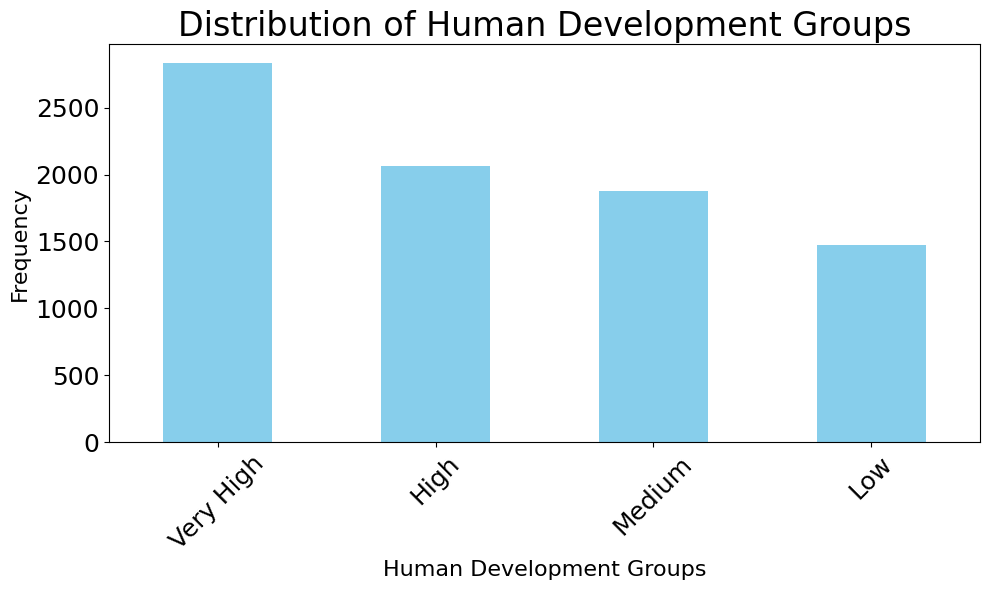

In [183]:
import matplotlib.pyplot as plt

# Assuming df_un_merged['Human Development Groups'] contains categorical data
# Value counts for each category
category_counts = df_un_merged['Human Development Groups'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Human Development Groups', size=16)
plt.ylabel('Frequency', size=16)
plt.title('Distribution of Human Development Groups', size=24)
plt.xticks(rotation=45, size=18)  # Rotate x-axis labels for better readability
plt.yticks(size=18)
plt.tight_layout()  # Ensure labels fit within the figure area
plt.savefig('development_labels.png')


## Some Imports

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.base import clone

## Data Split

In [208]:
# Drop rows with missing values
df_un_merged = df_un_merged.dropna()

# Split the data into training and testing sets
X = df_un_merged["Redacted_Speech"]
y = df_un_merged['Human Development Groups']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## GridSearch

For brevity, we only include the code to search the optimal parameters for ComplementNB (since some of the other algorithms can be quite slow.

In [187]:
# Define the pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('cnb', ComplementNB())
])

# Define the parameters for grid search
parameters = {
    'cnb__alpha': [ 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.015 ],
}

# Create a k-fold cross-validation object
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(text_clf, parameters, cv=kf, n_jobs=-1)

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate on the test set with the best estimator
best_clf = grid_search.best_estimator_
test_score = best_clf.score(X_test, y_test)
print("Test set accuracy with best estimator: {:.2f}".format(test_score))



Best parameters found:  {'cnb__alpha': 0.09}
Best cross-validation score: 0.72
Test set accuracy with best estimator: 0.70


## Complement NB Training & Evaluation

In [212]:
best_model = None
best_accuracy = 0

pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('cnb', ComplementNB(alpha=0.007))
    ])


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []


for train_index, val_index in tqdm(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation data
    y_val_pred = pipeline.predict(X_val_fold)
    
    # Calculate evaluation metrics for this fold
    precision = precision_score(y_val_fold, y_val_pred, average='macro')
    recall = recall_score(y_val_fold, y_val_pred, average='macro')
    f1 = f1_score(y_val_fold, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    
    # Append the scores for this fold
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clone(pipeline)  # Create a copy of the pipeline with the best performance

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

# Test the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
    

# Calculate mean and standard deviation for each evaluation metric
mean_precision = sum(precision_scores) / len(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = sum(recall_scores) / len(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = sum(f1_scores) / len(f1_scores)
std_f1 = np.std(f1_scores)

mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Display the mean and standard deviation for each evaluation metric
print('Mean Precision:', mean_precision)
print('Standard Deviation Precision:', std_precision)

print('Mean Recall:', mean_recall)
print('Standard Deviation Recall:', std_recall)

print('Mean F1 Score:', mean_f1)
print('Standard Deviation F1 Score:', std_f1)

print('Mean Accuracy:', mean_accuracy)
print('Standard Deviation Accuracy:', std_accuracy)


print('========')
# Display test 
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1:', test_f1)
print('Test Accuracy:', test_accuracy)


5it [00:23,  4.67s/it]


Mean Precision: 0.7690266102675493
Standard Deviation Precision: 0.014559415598805109
Mean Recall: 0.7548850826887227
Standard Deviation Recall: 0.010737716131642329
Mean F1 Score: 0.7465308931778247
Standard Deviation F1 Score: 0.012089765106614313
Mean Accuracy: 0.7618099547511312
Standard Deviation Accuracy: 0.010910890043874421
Test Precision: 0.7668685832956315
Test Recall: 0.758525641192994
Test F1: 0.7472192309275149
Test Accuracy: 0.7612049963262307


## Multinomial NB Training & Evaluation

In [ ]:
best_model = None
best_accuracy = 0

pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('mnb', MultinomialtNB(alpha=0.001))
    ])


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []


for train_index, val_index in tqdm(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation data
    y_val_pred = pipeline.predict(X_val_fold)
    
    # Calculate evaluation metrics for this fold
    precision = precision_score(y_val_fold, y_val_pred, average='macro')
    recall = recall_score(y_val_fold, y_val_pred, average='macro')
    f1 = f1_score(y_val_fold, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    
    # Append the scores for this fold
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clone(pipeline)  # Create a copy of the pipeline with the best performance

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

# Test the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
    

# Calculate mean and standard deviation for each evaluation metric
mean_precision = sum(precision_scores) / len(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = sum(recall_scores) / len(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = sum(f1_scores) / len(f1_scores)
std_f1 = np.std(f1_scores)

mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Display the mean and standard deviation for each evaluation metric
print('Mean Precision:', mean_precision)
print('Standard Deviation Precision:', std_precision)

print('Mean Recall:', mean_recall)
print('Standard Deviation Recall:', std_recall)

print('Mean F1 Score:', mean_f1)
print('Standard Deviation F1 Score:', std_f1)

print('Mean Accuracy:', mean_accuracy)
print('Standard Deviation Accuracy:', std_accuracy)


print('========')
# Display test 
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1:', test_f1)
print('Test Accuracy:', test_accuracy)

## Random Forest Training & Evaluation

In [92]:
best_model = None
best_accuracy = 0

pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('rforest', RandomForestClassifier(max_depth=50, n_estimators=100, class_weight='balanced'))
    ])


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []


for train_index, val_index in tqdm(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation data
    y_val_pred = pipeline.predict(X_val_fold)
    
    # Calculate evaluation metrics for this fold
    precision = precision_score(y_val_fold, y_val_pred, average='macro')
    recall = recall_score(y_val_fold, y_val_pred, average='macro')
    f1 = f1_score(y_val_fold, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    
    # Append the scores for this fold
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clone(pipeline)  # Create a copy of the pipeline with the best performance

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

# Test the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
    

# Calculate mean and standard deviation for each evaluation metric
mean_precision = sum(precision_scores) / len(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = sum(recall_scores) / len(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = sum(f1_scores) / len(f1_scores)
std_f1 = np.std(f1_scores)

mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Display the mean and standard deviation for each evaluation metric
print('Mean Precision:', mean_precision)
print('Standard Deviation Precision:', std_precision)

print('Mean Recall:', mean_recall)
print('Standard Deviation Recall:', std_recall)

print('Mean F1 Score:', mean_f1)
print('Standard Deviation F1 Score:', std_f1)

print('Mean Accuracy:', mean_accuracy)
print('Standard Deviation Accuracy:', std_accuracy)


print('========')
# Display test 
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1:', test_f1)
print('Test Accuracy:', test_accuracy)


5it [00:44,  8.82s/it]


Mean Precision: 0.5837416789709166
Standard Deviation Precision: 0.016732806290331068
Mean Recall: 0.5181976447810304
Standard Deviation Recall: 0.008360279434980626
Mean F1 Score: 0.5140310639039595
Standard Deviation F1 Score: 0.011065290800166352
Mean Accuracy: 0.5587330316742081
Standard Deviation Accuracy: 0.008653779611136243
Test Precision: 0.5979750931021897
Test Recall: 0.5586771810739065
Test F1: 0.5566687689989233
Test Accuracy: 0.5925789860396767


## AdaBoost Training & Evaluation

In [93]:

weak_learner = DecisionTreeClassifier(max_leaf_nodes=100, class_weight='balanced')
n_estimators = 120

pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('ada', AdaBoostClassifier(
        estimator=weak_learner,
        n_estimators=n_estimators,
        algorithm="SAMME",
        random_state=42, 
        ))
    ])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []


for train_index, val_index in tqdm(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation data
    y_val_pred = pipeline.predict(X_val_fold)
    
    # Calculate evaluation metrics for this fold
    precision = precision_score(y_val_fold, y_val_pred, average='macro')
    recall = recall_score(y_val_fold, y_val_pred, average='macro')
    f1 = f1_score(y_val_fold, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    
    # Append the scores for this fold
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clone(pipeline)  # Create a copy of the pipeline with the best performance

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

# Test the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
    

# Calculate mean and standard deviation for each evaluation metric
mean_precision = sum(precision_scores) / len(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = sum(recall_scores) / len(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = sum(f1_scores) / len(f1_scores)
std_f1 = np.std(f1_scores)

mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Display the mean and standard deviation for each evaluation metric
print('Mean Precision:', mean_precision)
print('Standard Deviation Precision:', std_precision)

print('Mean Recall:', mean_recall)
print('Standard Deviation Recall:', std_recall)

print('Mean F1 Score:', mean_f1)
print('Standard Deviation F1 Score:', std_f1)

print('Mean Accuracy:', mean_accuracy)
print('Standard Deviation Accuracy:', std_accuracy)


print('========')
# Display test 
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1:', test_f1)
print('Test Accuracy:', test_accuracy)

5it [1:12:16, 867.28s/it] 


Mean Precision: 0.6549729765389578
Standard Deviation Precision: 0.010493990433595984
Mean Recall: 0.6568209813875943
Standard Deviation Recall: 0.010215710866108145
Mean F1 Score: 0.654882873638114
Standard Deviation F1 Score: 0.010272415703192797
Mean Accuracy: 0.6707692307692308
Standard Deviation Accuracy: 0.010744486573506488
Test Precision: 0.6707084383741699
Test Recall: 0.6734067007132547
Test F1: 0.6715096806595323
Test Accuracy: 0.6862601028655401


## SVM Training & Evaluation

In [114]:
pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('svm_clf', svm.SVC(C=10, kernel='rbf', class_weight='balanced', probability=True))
    ])


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []


for train_index, val_index in tqdm(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation data
    y_val_pred = pipeline.predict(X_val_fold)
    
    # Calculate evaluation metrics for this fold
    precision = precision_score(y_val_fold, y_val_pred, average='macro')
    recall = recall_score(y_val_fold, y_val_pred, average='macro')
    f1 = f1_score(y_val_fold, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    
    # Append the scores for this fold
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clone(pipeline)  # Create a copy of the pipeline with the best performance

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

# Test the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
    

# Calculate mean and standard deviation for each evaluation metric
mean_precision = sum(precision_scores) / len(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = sum(recall_scores) / len(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = sum(f1_scores) / len(f1_scores)
std_f1 = np.std(f1_scores)

mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Display the mean and standard deviation for each evaluation metric
print('Mean Precision:', mean_precision)
print('Standard Deviation Precision:', std_precision)

print('Mean Recall:', mean_recall)
print('Standard Deviation Recall:', std_recall)

print('Mean F1 Score:', mean_f1)
print('Standard Deviation F1 Score:', std_f1)

print('Mean Accuracy:', mean_accuracy)
print('Standard Deviation Accuracy:', std_accuracy)


print('========')
# Display test 
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1:', test_f1)
print('Test Accuracy:', test_accuracy)



5it [3:50:30, 2766.04s/it]


Mean Precision: 0.8042265841316096
Standard Deviation Precision: 0.014172210523588455
Mean Recall: 0.8043200110685899
Standard Deviation Recall: 0.011297371312189393
Mean F1 Score: 0.8036964203697193
Standard Deviation F1 Score: 0.012533741805694422
Mean Accuracy: 0.8108597285067873
Standard Deviation Accuracy: 0.011909997376551743
Test Precision: 0.8219328977122384
Test Recall: 0.8208610750554849
Test F1: 0.8209413375964711
Test Accuracy: 0.8291697281410727


In [47]:
df_un_merged[df_un_merged['Human Development Groups'] == 'Very High' ].count()

Unnamed: 0                  2833
Country or Area             2833
Region Name                 2833
Sub-region Name             2833
ISO                         2833
Year                        2833
Speech                      2833
Human Development Groups    2833
HDI                         2833
Redacted_Speech             2833
dtype: int64

In [210]:
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test)
mat = confusion_matrix(y_test, y_pred)

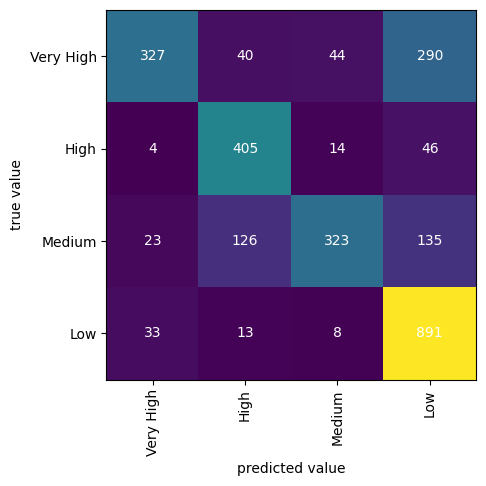

In [211]:
fig, ax = plt.subplots()
ax.imshow(mat, cmap='viridis', interpolation='nearest')
ax.set_xlabel('predicted value')
ax.set_ylabel('true value');
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
ax.set_xticklabels(y_train.unique(), rotation='vertical')
ax.set_yticklabels(y_train.unique())

# Loop over data to create text annotations.
for i in range(len(mat)):
    for j in range(len(mat)):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")
plt.show()